In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root="/kaggle/working",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="/kaggle/working",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 57.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.55MB/s]


In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out
        



In [7]:
ae = AutoEncoder().to(device)

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)


In [9]:
ae_losses = []

for epoch in range(20):
    ae.train()
    total_loss = 0
    
    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)
        
        optimizer.zero_grad()
        x_hat = ae(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    ae_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/20], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.0402
Epoch [2/20], Loss: 0.0153
Epoch [3/20], Loss: 0.0115
Epoch [4/20], Loss: 0.0097
Epoch [5/20], Loss: 0.0088
Epoch [6/20], Loss: 0.0081
Epoch [7/20], Loss: 0.0076
Epoch [8/20], Loss: 0.0072
Epoch [9/20], Loss: 0.0069
Epoch [10/20], Loss: 0.0066
Epoch [11/20], Loss: 0.0064
Epoch [12/20], Loss: 0.0062
Epoch [13/20], Loss: 0.0061
Epoch [14/20], Loss: 0.0059
Epoch [15/20], Loss: 0.0058
Epoch [16/20], Loss: 0.0057
Epoch [17/20], Loss: 0.0056
Epoch [18/20], Loss: 0.0055
Epoch [19/20], Loss: 0.0055
Epoch [20/20], Loss: 0.0054


In [10]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 256)
        self.fc_mu = nn.Linear(256, 32)
        self.fc_logvar = nn.Linear(256, 32)
        
        self.fc2 = nn.Linear(32, 256)
        self.fc3 = nn.Linear(256, 784)
        
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [11]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)


In [12]:
def vae_loss(x_hat, x, mu, logvar):
    recon = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl, recon, kl


In [13]:
vae_losses, kl_losses = [], []

for epoch in range(20):
    vae.train()
    total_loss, total_kl = 0, 0
    
    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)
        
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss, recon, kl = vae_loss(x_hat, x, mu, logvar)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_kl += kl.item()
    
    vae_losses.append(total_loss / len(train_loader))
    kl_losses.append(total_kl / len(train_loader))
    
    print(f"Epoch [{epoch+1}/20], Loss: {vae_losses[-1]:.2f}, KL: {kl_losses[-1]:.2f}")


Epoch [1/20], Loss: 22397.39, KL: 1972.02
Epoch [2/20], Loss: 16526.17, KL: 2708.70
Epoch [3/20], Loss: 15261.49, KL: 2983.46
Epoch [4/20], Loss: 14696.16, KL: 3109.82
Epoch [5/20], Loss: 14372.80, KL: 3185.05
Epoch [6/20], Loss: 14174.87, KL: 3226.95
Epoch [7/20], Loss: 14034.49, KL: 3252.31
Epoch [8/20], Loss: 13920.62, KL: 3264.38
Epoch [9/20], Loss: 13842.67, KL: 3279.35
Epoch [10/20], Loss: 13785.50, KL: 3290.97
Epoch [11/20], Loss: 13725.23, KL: 3296.30
Epoch [12/20], Loss: 13679.09, KL: 3303.96
Epoch [13/20], Loss: 13641.60, KL: 3310.52
Epoch [14/20], Loss: 13604.20, KL: 3314.46
Epoch [15/20], Loss: 13581.32, KL: 3320.13
Epoch [16/20], Loss: 13551.70, KL: 3320.82
Epoch [17/20], Loss: 13528.70, KL: 3324.74
Epoch [18/20], Loss: 13503.66, KL: 3325.92
Epoch [19/20], Loss: 13484.60, KL: 3331.30
Epoch [20/20], Loss: 13468.50, KL: 3332.39


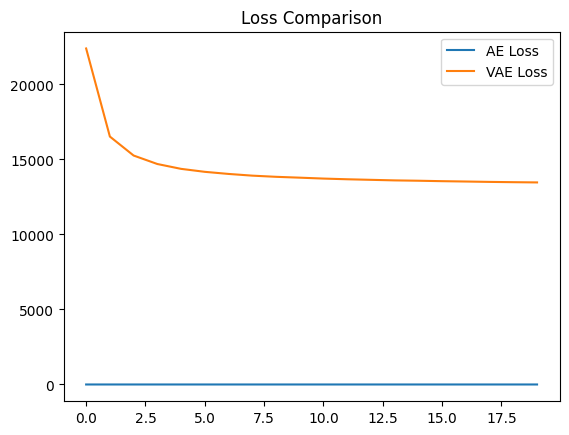

In [14]:
plt.plot(ae_losses, label="AE Loss")
plt.plot(vae_losses, label="VAE Loss")
plt.legend()
plt.title("Loss Comparison")
plt.show()


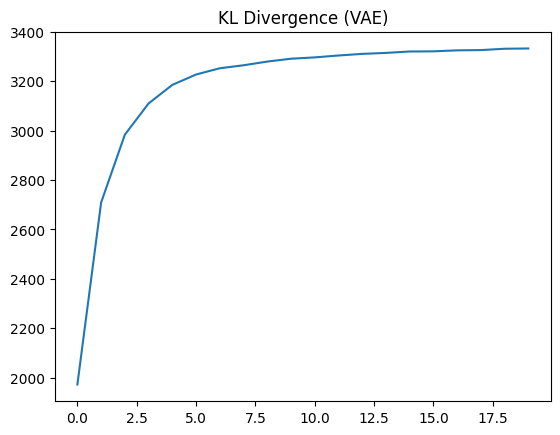

In [15]:
plt.plot(kl_losses, label="KL Divergence")
plt.title("KL Divergence (VAE)")
plt.show()


In [16]:
from sklearn.manifold import TSNE
import numpy as np


In [17]:
vae.eval()
latents, labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.view(-1, 784).to(device)
        mu, _ = vae.encode(x)
        latents.append(mu.cpu())
        labels.append(y)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()


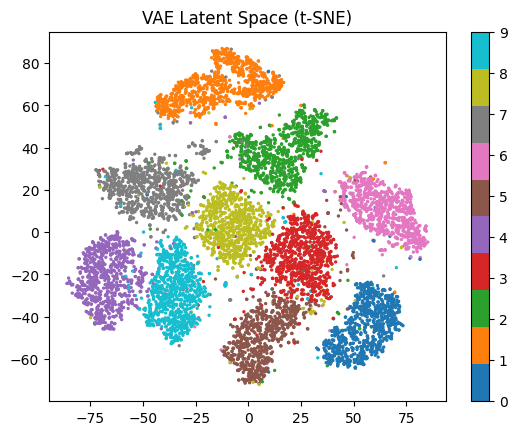

In [18]:
z_tsne = TSNE(n_components=2).fit_transform(latents)

plt.scatter(z_tsne[:,0], z_tsne[:,1], c=labels, cmap='tab10', s=2)
plt.colorbar()
plt.title("VAE Latent Space (t-SNE)")
plt.show()
